In [1]:
# Import libraries
import numpy as np
import seaborn as sns
import heapq
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from scipy.stats import ttest_ind

In [2]:
# Constants
NUM_TOP_MAPS = 1024         # Number of popular maps to select
NUM_TOP_PLAYERS = 1024      # Number of prolific players to select
REPRESENTATION_SIZE = 11    # Size of skill/difficulty embedding
NUM_EPOCHS = 1000           # Number of epochs to train for
BATCH_SIZE = 10000          # Number of scores per batch

In [3]:
# Load top players and maps
scores = pd.read_csv('AllScoresExtracted.csv')
scores = scores.query("Modifiers.isnull()").copy(deep=True)
top_players = scores['PlayerId'].value_counts().iloc[:NUM_TOP_PLAYERS].index.tolist()
scores = scores.query('PlayerId in @top_players').copy(deep=True)
top_maps = scores['LeaderboardId'].value_counts().iloc[:NUM_TOP_MAPS].index.tolist()
scores = scores.query('LeaderboardId in @top_maps').copy(deep=True)
scores['LeaderboardId'], maps = pd.factorize(scores['LeaderboardId'])
scores['PlayerId'], users = pd.factorize(scores['PlayerId'])

In [4]:
# Load models
model = tf.keras.models.load_model('saved_model')
map_model = tf.keras.models.load_model('saved_map_model')

In [5]:
# Evaluate map ranks
test_maps = tf.one_hot(range(NUM_TOP_MAPS), depth=NUM_TOP_MAPS)
test_ranks = map_model.predict(test_maps, batch_size=BATCH_SIZE)

1/1 [==============================] - 0s 264ms/step


In [6]:
# Normalize map ranks
test_ranks = [rank / np.linalg.norm(rank) for rank in test_ranks]

In [7]:
# # Get tags
# import requests
# import json

# def get_tags(lid: str):
#     response = requests.get(f'https://api.beatleader.xyz/leaderboard/{lid}', {'accept': 'text/plain'})
#     return response.json()['song']['tags']

# with_tags = pd.DataFrame({'LeaderboardId': maps})
# with_tags['tags'] = with_tags['LeaderboardId'].apply(get_tags)

# with_tags.to_csv('LID_and_tags.csv', index=False)  # Save this so we don't have to spam requests
with_tags = pd.read_csv('LID_and_tags.csv')
with_tags['test_ranks'] = test_ranks
# with_mappers_no_collab = with_mappers[~with_mappers['mapper'].str.contains('(\&|\,|\svs\.)', regex=True)]   # Remove collab maps
# with_mappers_no_collab


In [8]:
# Remove NaN
with_tags_noNaN = with_tags[with_tags['tags'].notnull()]

In [9]:
with_tags_noNaN

,LeaderboardId,tags,test_ranks
0,16e9791,speed,"[0.33214077, -0.3331743, -0.50072366, -0.22835..."
2,d4a571,"j-pop,house","[0.20471643, -0.2148198, -0.27308458, -0.36335..."
5,1aafc71,"electronic,tech","[0.29602557, -0.41023055, -0.297744, -0.333363..."
7,1a56891,"tech,electronic,house","[0.36240295, -0.24587238, -0.40171432, -0.2644..."
8,19be191,balanced,"[0.39285612, -0.19734755, -0.24865651, -0.3001..."
...,...,...,...
1019,28523xxxxxx91,"tech,jazz,anime","[0.0322152, -0.34822726, -0.45311615, 0.018742..."
1020,28541xxxxxx91,"tech,anime,swing","[0.05191932, -0.3218564, -0.4514492, -0.239431..."
1021,1fd62xxx51,"tech,challenge,dance,electronic","[0.20302303, -0.37476328, -0.19414923, -0.3580..."
1022,2fa0471,"balanced,dance-style,tv-movie-soundtrack,rock","[0.13885148, -0.19151832, -0.2834947, -0.36079..."


In [10]:
# Get unique tags

unique_tags = set()

for map_tags in with_tags_noNaN['tags'].tolist():
    tags = str(map_tags).split(',')
    for t in tags:
        unique_tags.add(t)

unique_tags = list(unique_tags)


In [11]:
# Random maps vs. >= 1 tag in common

NUM_SAMPLES = 1000

random_dotprods = []
common_tag_dotprods = []

for i in range(NUM_SAMPLES):
    pool_sample = random.sample(test_ranks, 2)
    random_dotprods.append(np.dot(pool_sample[0], pool_sample[1]))

    while True:
        tag_choice = random.choice(unique_tags)
        test_ranks_by_tag = with_tags_noNaN[with_tags_noNaN['tags'].str.contains(tag_choice)]['test_ranks'].tolist()
        if len(test_ranks_by_tag) >= 2:
            break

    tag_sample = random.sample(test_ranks_by_tag, 2)
    common_tag_dotprods.append(np.dot(tag_sample[0], tag_sample[1]))

ttest_result = ttest_ind(random_dotprods, common_tag_dotprods)

print(f'Mean dot product of 2 random maps: {np.mean(random_dotprods)}')
print(f'SD of ^: {np.std(random_dotprods)}')
print(f'Mean dot product of 2 maps with at least 1 random tag in common: {np.mean(common_tag_dotprods)}')
print(f'SD of ^: {np.std(common_tag_dotprods)}')
print(f'Sample size: {NUM_SAMPLES}')
print(f't-value: {ttest_result.statistic}')
print(f'p-value: {ttest_result.pvalue}')

Mean dot product of 2 random maps: 0.8883180618286133
SD of ^: 0.08632424473762512
Mean dot product of 2 maps with at least 1 random tag in common: 0.9074576497077942
SD of ^: 0.07791212946176529
Sample size: 1000
t-value: -5.202259930958126
p-value: 2.1703309261768782e-07


In [12]:
# Random maps vs. Maps with identical tags

NUM_SAMPLES = 1000

random_dotprods = []
identical_tagset_dotprods = []

unique_tagsets = with_tags_noNaN['tags'].unique().tolist()

for i in range(NUM_SAMPLES):
    pool_sample = random.sample(test_ranks, 2)
    random_dotprods.append(np.dot(pool_sample[0], pool_sample[1]))

    while True:
        tagset_choice = random.choice(unique_tagsets)
        test_ranks_by_tagset = with_tags_noNaN[with_tags_noNaN['tags'] == tagset_choice]['test_ranks'].tolist()
        if len(test_ranks_by_tagset) >= 2:
            break

    tagset_sample = random.sample(test_ranks_by_tagset, 2)
    identical_tagset_dotprods.append(np.dot(tagset_sample[0], tagset_sample[1]))

ttest_result = ttest_ind(random_dotprods, identical_tagset_dotprods)

print(f'Mean dot product of 2 random maps: {np.mean(random_dotprods)}')
print(f'SD of ^: {np.std(random_dotprods)}')
print(f'Mean dot product of 2 maps with identical sets of tags: {np.mean(identical_tagset_dotprods)}')
print(f'SD of ^: {np.std(identical_tagset_dotprods)}')
print(f'Sample size: {NUM_SAMPLES}')
print(f't-value: {ttest_result.statistic}')
print(f'p-value: {ttest_result.pvalue}')

Mean dot product of 2 random maps: 0.8858744502067566
SD of ^: 0.09081141650676727
Mean dot product of 2 maps with identical sets of tags: 0.9046586155891418
SD of ^: 0.08536538481712341
Sample size: 1000
t-value: -4.763580740011342
p-value: 2.0387552926483693e-06


Mean: 0.8716291785240173
SD: 0.10072201490402222


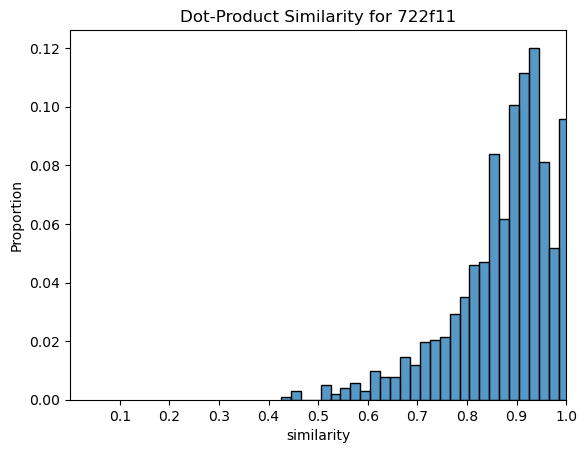

In [13]:
# Visualize Similarity distributions

lid = '722f11'

target_rank = test_ranks[list(maps).index(lid)]

sim_values = []

for rank in test_ranks:
    sim_values.append(np.dot(target_rank, rank))

sim_values_df = pd.DataFrame({'similarity': sim_values})
simhist = sns.histplot(data=sim_values_df, x='similarity', stat='proportion', binwidth=0.02)
simhist.set_xlim(0, 1)
plt.title(f'Dot-Product Similarity for {lid}')
plt.xticks([n / 10 for n in range(1, 11)])
print(f'Mean: {np.mean(sim_values)}')
print(f'SD: {np.std(sim_values)}')

In [14]:
standard_devs = []
max_sd = 0
max_lid = ''

for lid in maps:
    target_rank = test_ranks[list(maps).index(lid)]
    sim_values = []

    for rank in test_ranks:
        sim_values.append(np.dot(target_rank, rank))
    
    sd = np.std(sim_values)
    standard_devs.append(sd)
    if sd > max_sd:
        max_sd = sd
        max_lid = lid

max_sd


    

0.100722015

In [15]:
from scipy.stats import pointbiserialr



In [16]:
# Make columns out of each dimension and each tag
temp = pd.DataFrame(with_tags_noNaN)
temp[['tr_0', 'tr_1', 'tr_2', 'tr_3', 'tr_4', 'tr_5', 'tr_6', 'tr_7', 'tr_8', 'tr_9', 'tr_10']] = pd.DataFrame(temp.test_ranks.tolist(), index=temp.index)
ranks_tags = temp.drop(['test_ranks'], axis=1)

for t in unique_tags:
    ranks_tags[t] = ranks_tags['tags'].str.contains(t)

ranks_tags

,LeaderboardId,tags,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,...,drum-and-bass,house,electronic,pop,dance,tech,folk-acoustic,speedcore,rock,accuracy
0,16e9791,speed,0.332141,-0.333174,-0.500724,-0.228354,-0.415391,0.291072,-0.056030,0.312869,...,False,False,False,False,False,False,False,False,False,False
2,d4a571,"j-pop,house",0.204716,-0.214820,-0.273085,-0.363355,-0.180225,0.257880,-0.329393,0.375243,...,False,True,False,True,False,False,False,False,False,False
5,1aafc71,"electronic,tech",0.296026,-0.410231,-0.297744,-0.333364,-0.406333,0.344414,-0.351070,0.180970,...,False,False,True,False,False,True,False,False,False,False
7,1a56891,"tech,electronic,house",0.362403,-0.245872,-0.401714,-0.264436,-0.166045,0.425821,-0.037667,0.441485,...,False,True,True,False,False,True,False,False,False,False
8,19be191,balanced,0.392856,-0.197348,-0.248657,-0.300111,-0.333898,0.240987,-0.409026,0.209454,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,28523xxxxxx91,"tech,jazz,anime",0.032215,-0.348227,-0.453116,0.018743,-0.282510,0.318925,-0.091416,0.212729,...,False,False,False,False,False,True,False,False,False,False
1020,28541xxxxxx91,"tech,anime,swing",0.051919,-0.321856,-0.451449,-0.239432,-0.191987,0.530679,-0.115942,0.382837,...,False,False,False,False,False,True,False,False,False,False
1021,1fd62xxx51,"tech,challenge,dance,electronic",0.203023,-0.374763,-0.194149,-0.358056,-0.296607,0.326999,-0.291912,0.333578,...,False,False,True,False,True,True,False,False,False,False
1022,2fa0471,"balanced,dance-style,tv-movie-soundtrack,rock",0.138851,-0.191518,-0.283495,-0.360793,-0.239280,0.280249,-0.338426,0.327818,...,False,False,False,False,True,False,False,False,True,False


In [17]:
# Point biserial correlation of tags and each of the dimensions (no PCA)
pb_corr = []
for t in unique_tags:
    corr = []
    for i in range(2, 13):  # Go through all rank vector element columns
        component = ranks_tags.iloc[:, i]
        pb = pointbiserialr(ranks_tags[t], component)
        corr.append(pb.statistic)
    pb_corr.append(corr)

with_pb = pd.DataFrame({'tags': unique_tags, 'pb_corr': pb_corr})
with_pb[['tr_0', 'tr_1', 'tr_2', 'tr_3', 'tr_4', 'tr_5', 'tr_6', 'tr_7', 'tr_8', 'tr_9', 'tr_10']] = pd.DataFrame(with_pb.pb_corr.tolist(), index=with_pb.index)
with_pb
        

,tags,pb_corr,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,tr_10
0,metal,"[0.055349376718316384, -0.05652026544972142, 0...",0.055349,-0.056520,0.078849,-0.084494,0.034755,-0.050529,0.007327,-0.049538,-0.020223,-0.009732,-0.047782
1,classical-orchestral,"[-0.009154258904796216, 0.0011170628626888598,...",-0.009154,0.001117,-0.048415,0.029821,-0.032340,0.031076,0.083434,0.045751,-0.028736,-0.016686,0.029331
2,j-rock,"[0.038942409576488035, 0.043442199943469546, -...",0.038942,0.043442,-0.001104,-0.037930,-0.017952,0.007068,-0.018505,0.071422,-0.027168,0.047606,0.065426
3,anime,"[-0.1084237193756519, -0.021867429509372344, 0...",-0.108424,-0.021867,0.015465,0.012886,-0.019519,0.044329,-0.004557,0.071821,0.010799,0.044889,0.042539
4,vocaloid,"[-0.0005239426291527727, 0.1112514262059575, -...",-0.000524,0.111251,-0.013605,-0.019438,-0.010603,-0.006511,-0.021495,0.012655,0.031064,0.079328,0.000512
5,video-game-soundtrack,"[0.005341505347903749, 0.027153364085170776, -...",0.005342,0.027153,-0.029604,-0.030645,0.044451,-0.038852,-0.034906,0.018550,-0.046839,0.064080,-0.041342
6,punk,"[-0.0206882334183958, 0.04493959774267953, 0.0...",-0.020688,0.044940,0.034932,-0.083945,0.033838,-0.025721,-0.029752,0.036965,-0.011122,0.027756,-0.055570
7,fitness,"[-0.036878553271667995, 0.08069546561239249, -...",-0.036879,0.080695,-0.041897,0.096374,-0.006263,0.149412,-0.053679,0.054704,-0.060946,-0.035515,0.063932
8,soul,"[0.014350092656811564, -0.04458758172418391, -...",0.014350,-0.044588,-0.015193,0.059628,-0.031330,0.061389,0.078050,0.018674,0.005482,-0.090942,-0.022398
9,balanced,"[0.09337243576129599, -0.0012657521437109236, ...",0.093372,-0.001266,0.116404,-0.093838,-0.200456,-0.136622,-0.125445,0.004725,-0.024559,0.007332,-0.182960


In [18]:
with_tags_noNaN

,LeaderboardId,tags,test_ranks,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,tr_10
0,16e9791,speed,"[0.33214077, -0.3331743, -0.50072366, -0.22835...",0.332141,-0.333174,-0.500724,-0.228354,-0.415391,0.291072,-0.056030,0.312869,0.134392,0.192739,-0.249598
2,d4a571,"j-pop,house","[0.20471643, -0.2148198, -0.27308458, -0.36335...",0.204716,-0.214820,-0.273085,-0.363355,-0.180225,0.257880,-0.329393,0.375243,0.272069,0.320062,-0.424959
5,1aafc71,"electronic,tech","[0.29602557, -0.41023055, -0.297744, -0.333363...",0.296026,-0.410231,-0.297744,-0.333364,-0.406333,0.344414,-0.351070,0.180970,0.136229,0.260115,-0.135467
7,1a56891,"tech,electronic,house","[0.36240295, -0.24587238, -0.40171432, -0.2644...",0.362403,-0.245872,-0.401714,-0.264436,-0.166045,0.425821,-0.037667,0.441485,0.209707,0.267682,-0.236764
8,19be191,balanced,"[0.39285612, -0.19734755, -0.24865651, -0.3001...",0.392856,-0.197348,-0.248657,-0.300111,-0.333898,0.240987,-0.409026,0.209454,0.305761,0.315873,-0.284288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,28523xxxxxx91,"tech,jazz,anime","[0.0322152, -0.34822726, -0.45311615, 0.018742...",0.032215,-0.348227,-0.453116,0.018743,-0.282510,0.318925,-0.091416,0.212729,0.448181,0.485483,-0.018388
1020,28541xxxxxx91,"tech,anime,swing","[0.05191932, -0.3218564, -0.4514492, -0.239431...",0.051919,-0.321856,-0.451449,-0.239432,-0.191987,0.530679,-0.115942,0.382837,0.238774,0.307637,-0.049398
1021,1fd62xxx51,"tech,challenge,dance,electronic","[0.20302303, -0.37476328, -0.19414923, -0.3580...",0.203023,-0.374763,-0.194149,-0.358056,-0.296607,0.326999,-0.291912,0.333578,0.262015,0.328821,-0.290293
1022,2fa0471,"balanced,dance-style,tv-movie-soundtrack,rock","[0.13885148, -0.19151832, -0.2834947, -0.36079...",0.138851,-0.191518,-0.283495,-0.360793,-0.239280,0.280249,-0.338426,0.327818,0.329171,0.314038,-0.410775


In [23]:
# Perform PCA on ranks without 'NaN' tags

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

N_COMPONENTS = 11

scale = StandardScaler()

ranks_noNaN = np.array(with_tags_noNaN.iloc[:,3:14])    # Get just the test rank vector values
ranks_noNaN_scaled = scale.fit_transform(ranks_noNaN)   # Standardize ranks


# PCA
pca = PCA(n_components=N_COMPONENTS)
ranks_pca = pca.fit_transform(ranks_noNaN_scaled)
print('Singular values: ', pca.singular_values_)
print('Variance captured: ', sum(pca.explained_variance_ratio_))
pd.DataFrame(pca.components_.T)



Singular values:  [42.6279   28.545809 26.756193 23.893547 22.18728  21.32284  21.047802
 19.704468 17.829433 17.086231  7.152681]
Variance captured:  1.00000006146729


,0,1,2,3,4,5,6,7,8,9,10
0,0.280290,-0.347010,-0.169078,0.029803,-0.419625,0.284273,-0.651164,-0.023688,0.011797,-0.008160,-0.299781
1,-0.198692,0.513162,-0.006764,0.428254,-0.418162,-0.210050,-0.324476,0.230585,-0.099689,0.127168,0.331956
2,-0.317872,-0.436944,0.213302,-0.232174,0.063375,-0.382015,-0.387378,-0.251821,0.057836,-0.104022,0.480668
3,0.430580,-0.026527,0.013869,0.221258,-0.115004,-0.066760,0.136836,0.048018,0.127969,-0.797679,0.270867
4,-0.065367,0.480149,0.377977,-0.439279,-0.128263,0.442045,-0.146376,-0.216209,0.351547,-0.140394,0.077640
5,0.283858,0.406401,-0.108329,-0.227827,0.291177,-0.568806,-0.339857,-0.140418,-0.043361,-0.116635,-0.362760
6,0.415994,0.075081,-0.030838,-0.339475,-0.145929,0.095988,0.083466,-0.174292,-0.681256,0.164661,0.382153
7,-0.227447,-0.012886,-0.369338,-0.376451,-0.636612,-0.300538,0.342625,-0.105659,0.120267,-0.095236,-0.149291
8,0.090634,-0.109775,0.776791,0.154978,-0.312171,-0.244373,0.160194,-0.099508,-0.178863,0.047087,-0.354078
9,-0.352503,0.105187,-0.153333,0.339573,0.051805,0.180157,-0.010936,-0.691616,-0.332460,-0.275956,-0.159947


In [24]:
ranks_pca = pd.DataFrame(ranks_pca)
ranks_pca


,0,1,2,3,4,5,6,7,8,9,10
0,2.178745,0.128223,-2.647445,-0.238254,-0.018446,0.963353,1.103241,1.096790,-1.057221,0.483964,0.139820
1,-2.120295,0.906269,0.135972,-0.849788,-0.604152,0.259760,0.226404,0.284442,-0.142976,-0.234765,0.114602
2,0.682426,-0.981237,-1.645499,0.344347,2.209563,0.122584,-0.273711,-0.241101,0.758126,0.862196,-0.007855
3,1.404267,1.843504,-1.597512,-1.848304,-1.550820,0.196879,-0.116163,-0.633133,-0.561237,-0.010289,-0.118283
4,-0.699458,-0.729121,0.248884,1.432513,-0.281948,0.272985,-1.310614,0.272889,0.133835,0.127767,-0.019243
...,...,...,...,...,...,...,...,...,...,...,...
573,2.460272,1.477519,1.347808,1.995012,0.603764,-0.145576,3.372069,-2.540242,-0.920106,-1.439697,0.539823
574,1.726129,3.085018,-1.050376,-1.150087,0.769911,-1.182467,2.079997,-1.684544,0.264038,0.244091,-0.115986
575,-1.101855,-0.589962,-0.234336,-1.031179,0.787979,-0.634677,0.343416,-0.857482,-0.101325,0.063026,0.080159
576,-1.971284,1.043488,0.713285,-0.160478,-0.154836,-0.395356,0.574084,0.465916,-0.470914,-0.004289,0.046884


In [32]:
# Point biserial correlation of each tag and PC1 through PC11
pb_corr = []
p_values = []
for t in unique_tags:
    corr = []
    tag_p = []
    for i in range(N_COMPONENTS):  # Go through all rank vector element columns
        component = ranks_pca.iloc[:, i]
        pb = pointbiserialr(ranks_tags[t], component)
        corr.append(pb.statistic)
        tag_p.append(pb.pvalue)
    pb_corr.append(corr)
    p_values.append(tag_p)

with_pb = pd.DataFrame({'tags': unique_tags, 'pb_corr': pb_corr, 'p_values': p_values})
with_pb[[f'corr_PC{i}' for i in range(1, N_COMPONENTS + 1)]] = pd.DataFrame(with_pb.pb_corr.tolist(), index=with_pb.index)
with_pb[[f'pvalue_PC{i}' for i in range(1, N_COMPONENTS + 1)]] = pd.DataFrame(with_pb.p_values.tolist(), index=with_pb.index)
with_pb = with_pb.drop('pb_corr', axis=1)
with_pb = with_pb.drop('p_values', axis=1)
with_pb


,tags,corr_PC1,corr_PC2,corr_PC3,corr_PC4,corr_PC5,corr_PC6,corr_PC7,corr_PC8,corr_PC9,...,pvalue_PC2,pvalue_PC3,pvalue_PC4,pvalue_PC5,pvalue_PC6,pvalue_PC7,pvalue_PC8,pvalue_PC9,pvalue_PC10,pvalue_PC11
0,metal,-0.030522,-0.069030,0.029719,-0.066796,0.038144,0.080806,-0.083429,-0.000608,-0.016517,...,9.732098e-02,0.475788,1.086719e-01,0.359983,0.052176,0.044972,9.883654e-01,0.691903,0.182436,0.410235
1,classical-orchestral,0.042550,0.023866,-0.058959,-0.022783,-0.027033,-0.026500,0.050714,-0.004745,-0.052183,...,5.669094e-01,0.156885,5.846418e-01,0.516583,0.524883,0.223454,9.093772e-01,0.210312,0.793424,0.150862
2,j-rock,-0.015835,0.008682,-0.067209,0.026939,-0.066908,-0.025741,-0.020520,-0.071972,0.034739,...,8.350093e-01,0.106498,5.180387e-01,0.108079,0.536834,0.622492,8.384162e-02,0.404489,0.161564,0.229667
3,anime,-0.015774,0.025507,-0.016722,-0.012119,0.022539,-0.099729,0.104984,-0.084615,0.013031,...,5.405428e-01,0.688286,7.712451e-01,0.588669,0.016465,0.011553,4.199839e-02,0.754562,0.561461,0.779955
4,vocaloid,-0.036219,0.049819,0.000697,0.087589,-0.060683,-0.019430,-0.025894,-0.029838,-0.044953,...,2.317424e-01,0.986657,3.526699e-02,0.145085,0.641098,0.534415,4.740216e-01,0.280606,0.777527,0.579643
5,video-game-soundtrack,-0.047027,0.033972,-0.031801,0.009563,-0.016430,0.078789,-0.009270,-0.006744,0.003461,...,4.149517e-01,0.445406,8.185526e-01,0.693449,0.058351,0.824008,8.714720e-01,0.933827,0.585812,0.211914
6,punk,-0.070404,0.020497,0.003602,-0.028226,-0.022641,0.007735,-0.024004,0.008712,-0.012458,...,6.228789e-01,0.931136,4.982350e-01,0.586978,0.852788,0.564660,8.344431e-01,0.765034,0.367033,0.924190
7,fitness,0.038650,0.106115,-0.077437,0.026627,-0.001608,-0.142387,-0.011350,0.018482,0.119794,...,1.068415e-02,0.062818,5.228921e-01,0.969235,0.000596,0.785404,6.574738e-01,0.003924,0.050500,0.982917
8,soul,0.064781,-0.014725,-0.011039,-0.072169,-0.001744,-0.052645,0.017073,0.064592,-0.046620,...,7.238944e-01,0.791146,8.299505e-02,0.966626,0.206299,0.682102,1.208638e-01,0.263135,0.347223,0.981611
9,balanced,-0.116403,-0.201717,-0.050508,0.064534,0.000193,-0.007631,-0.088761,0.173861,-0.090525,...,1.011195e-06,0.225344,1.211997e-01,0.996312,0.854742,0.032879,2.635169e-05,0.029546,0.942982,0.000906


In [28]:
# Save this df
# with_pb.to_csv("Tags_PC_Correlations_DF.csv", index=False)

In [26]:
# EDA
for i in range(N_COMPONENTS):
    SORT_BY = f'corr_PC{i + 1}'
    TOP = 10

    sorted = with_pb.sort_values(SORT_BY, ascending=False)
    sorted.reset_index()

    print(f'Top {TOP} {SORT_BY}:')
    print()
    for i in range(TOP):
        print(sorted['tags'].iloc[i], sorted[SORT_BY].iloc[i])
    print()
    print(f'Bottom {TOP} {SORT_BY}:')
    print()
    for i in range(1, TOP + 1):
        print(sorted['tags'].iloc[-i], sorted[SORT_BY].iloc[-i])
    print()

Top 10 corr_PC1:

speed 0.3173261548901547
speedcore 0.211025484049827
tech 0.17123615796083652
hardcore 0.14757443585532293
soul 0.06478060969129487
dubstep 0.06401211022563465
classical-orchestral 0.0425504435576497
fitness 0.03864997347600376
electronic 0.03253270186857611
jazz 0.02538222624084391

Bottom 10 corr_PC1:

pop -0.22564893386727414
accuracy -0.1387929889657138
dance -0.1240475634386527
balanced -0.11640309060098963
indie -0.10700094987854558
j-pop -0.10437142941189997
k-pop -0.10397701538827563
dance-style -0.08940175813319456
rock -0.08160474071209892
punk -0.07040357703343351

Top 10 corr_PC2:

dance 0.18218933457470865
dance-style 0.1676551748431676
tech 0.14928933581573975
pop 0.12162635881887887
fitness 0.10611486597004546
j-pop 0.08052344204620288
house 0.07858005013038831
tv-movie-soundtrack 0.0694564426440214
funk-disco 0.06679614380967668
folk-acoustic 0.05364784531956832

Bottom 10 corr_PC2:

speed -0.2888983592244204
balanced -0.20171665671803357
speedcore -0.